In [1]:
import torch
import torch.nn as nn
import torchinfo

### Define networks

In [2]:
from standalone_nets.transformer import TransformerRefine
from standalone_nets.basenetworks import BASE_FACTORIES
from standalone_nets.joiner import HeadNet, Joiner

In [3]:
resnet50_factory = BASE_FACTORIES['resnet50']
rn50_dc5 = resnet50_factory(pool0_stride=2, block5_dilation=2)

swin_s_factory = BASE_FACTORIES['swin_s']
swin_s_s16 = swin_s_factory(use_fpn=True, fpn_level=3)

In [4]:
# base_net
base_net = rn50_dc5

# head_net
transformer = TransformerRefine(in_channels=base_net.out_features, out_channels=256, embed_dim=256, mlp_ratio=8., num_heads=8)
raf_head = torch.nn.Conv2d(256, 350, kernel_size=1, padding=0, dilation=1)
head_net = HeadNet(transformer, raf_head)

# Model
model = Joiner(base_net, head_net)

In [5]:
x = torch.randn(1, 3, 512, 512)

In [6]:
torchinfo.summary(model, input_data=x)

Layer (type:depth-idx)                             Output Shape              Param #
Joiner                                             --                        --
├─HeadNet: 1                                       --                        --
│    └─TransformerRefine: 2                        --                        --
│    │    └─ModuleList: 3-1                        --                        7,885,824
├─Resnet: 1-1                                      [1, 2048, 32, 32]         --
│    └─Sequential: 2-1                             [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-2                            [1, 64, 256, 256]         9,408
│    │    └─BatchNorm2d: 3-3                       [1, 64, 256, 256]         128
│    │    └─ReLU: 3-4                              [1, 64, 256, 256]         --
│    │    └─MaxPool2d: 3-5                         [1, 64, 128, 128]         --
│    └─Sequential: 2-2                             [1, 256, 128, 128]        --
│    │    └─Bottleneck: 

### Load weights

In [53]:
def adapt_state_dict(state_dict, orig_str, new_str):
    return {k.replace(orig_str, new_str): v for k, v in state_dict.items()}

In [54]:
checkpoint = torch.load("~/Downloads/state_dict_resnet50_doubleTransf.pt", map_location=torch.device('cuda'))
checkpoint = adapt_state_dict(checkpoint, "head_nets.1", "head_net")
missing_keys = model.load_state_dict(checkpoint, strict=False)
model.eval()
print(missing_keys)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['head_nets.0.transformer.input_proj.weight', 'head_nets.0.transformer.input_proj.bias', 'head_nets.0.transformer.blocks.0.norm1.weight', 'head_nets.0.transformer.blocks.0.norm1.bias', 'head_nets.0.transformer.blocks.0.attn.qkv.weight', 'head_nets.0.transformer.blocks.0.attn.proj.weight', 'head_nets.0.transformer.blocks.0.attn.proj.bias', 'head_nets.0.transformer.blocks.0.norm2.weight', 'head_nets.0.transformer.blocks.0.norm2.bias', 'head_nets.0.transformer.blocks.0.mlp.fc1.weight', 'head_nets.0.transformer.blocks.0.mlp.fc1.bias', 'head_nets.0.transformer.blocks.0.mlp.fc2.weight', 'head_nets.0.transformer.blocks.0.mlp.fc2.bias', 'head_nets.0.transformer.blocks.1.norm1.weight', 'head_nets.0.transformer.blocks.1.norm1.bias', 'head_nets.0.transformer.blocks.1.attn.qkv.weight', 'head_nets.0.transformer.blocks.1.attn.proj.weight', 'head_nets.0.transformer.blocks.1.attn.proj.bias', 'head_nets.0.transformer.blocks.1.norm2.weight', 'head_nets.

In [55]:
sample_attn = model.get_last_selfattention(x.cuda())

In [47]:
sample_attn.shape

AttributeError: 'list' object has no attribute 'shape'

## Visualize attention

In [11]:
from einops import rearrange
import matplotlib.pyplot as plt
import os
import torchvision.transforms as transforms
import torchvision
from PIL import Image
from skimage import exposure 
import numpy as np
import cv2

In [214]:
def get_attentions(model, image_path, stride=16, image_size=512):
    if os.path.isfile(image_path):
        with open(image_path, 'rb') as f:
            img = Image.open(f)
            img = img.convert('RGB')
    else:
        raise ValueError(f"Provided image path {image_path} is non valid.")
        
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop([512, 512]),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    img = transform(img)

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)

    h, w = img.shape[1] - img.shape[1] % stride, img.shape[2] - img.shape[2] % stride
    img = img[:, :h, :w].unsqueeze(0)

    h = img.shape[-2] // stride
    w = img.shape[-1] // stride

    with torch.no_grad():
        self_attns = model.get_last_selfattention(img.to(device))
    new_self_attns = []
    for self_attn in self_attns:    
        self_attn = rearrange(self_attn[0], "nh hw1 hw2 -> hw1 nh hw2")
        self_attn = rearrange(self_attn, "(h1 w1) nh (h2 w2) -> h1 w1 nh h2 w2", h1=h, w1=w, h2=h, w2=w)
        new_self_attns.append(self_attn)
    
    img = torchvision.utils.make_grid(img, normalize=True, scale_each=True)
    
    return img, new_self_attns

        
def attentions_at_loc(img, attentions, loc_h, loc_w, stride=16, scale=4, rescale=True, threshold=None, mask_below=0.05):
    box_img = draw_box_on_img(img, loc_h, loc_w, stride)
    
    attentions = attentions[loc_h, loc_w]
    nh, h, w = attentions.shape
        
    if threshold is not None:
        # we keep only a certain percentage of the mass
        attentions = attentions.reshape(nh, h * w)
        val, idx = torch.sort(attentions)
        val /= torch.sum(val, dim=1, keepdim=True)
        cumval = torch.cumsum(val, dim=1)
        th_attn = cumval > (1 - threshold)
        idx2 = torch.argsort(idx)
        for head in range(nh):
            th_attn[head] = th_attn[head][idx2[head]]
        attentions = attentions * th_attn.float()
        attentions = attentions.reshape(nh, h, w)
        
    if mask_below is not None:
        zeros_all = torch.zeros_like(attentions)
        attentions = torch.where(attentions < mask_below, zeros_all, attentions)
        
    


    avg_attn = nn.functional.interpolate(
        attentions.unsqueeze(0), scale_factor=stride, mode="bilinear")[0]
    
    avg_attn = avg_attn.mean(dim=0)
    # avg_attn = (avg_attn - avg_attn.min()) / (avg_attn.max() - avg_attn.min()).cpu().numpy()
    
    heatmap_avg = exposure.rescale_intensity(avg_attn.cpu().numpy(), out_range=(0, 255))
    heatmap_avg = np.uint8(heatmap_avg)
    heatmap_avg = cv2.applyColorMap(heatmap_avg, cv2.COLORMAP_VIRIDIS)
    img_np = np.uint8(exposure.rescale_intensity(img.permute(1, 2, 0).cpu().numpy(), out_range=(0, 255)))
    img_np = cv2.addWeighted(heatmap_avg, 1.0, img_np, 0.3, 0)

    

    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=stride, mode="bilinear")[0]
    attn_grid = torchvision.utils.make_grid(attentions.unsqueeze(1), normalize=True, scale_each=True, nrow=nh//2, pad_value=0.0)
    attn_grid = attn_grid.mean(dim=0)
    
    cool_img = make_cool_image(attentions, img, box_img)
    
    img_grid = torchvision.utils.make_grid([img for _ in range(nh)], nrow=nh//2)
    
    heatmap_img = exposure.rescale_intensity(attn_grid.cpu().numpy(), out_range=(0, 255))
    heatmap_img = np.uint8(heatmap_img)
    heatmap_img = cv2.applyColorMap(heatmap_img, cv2.COLORMAP_VIRIDIS)
    attn_grid = exposure.rescale_intensity(attn_grid.cpu().numpy(), out_range=(0, 255))
    img_grid = np.uint8(exposure.rescale_intensity(img_grid.permute(1, 2, 0).cpu().numpy(), out_range=(0, 255)))
    img_grid = cv2.addWeighted(heatmap_img, 1.2, img_grid, 0.2, 0)
    
    box_img = box_img.to(torch.float32) / 255
    box_img = box_img.permute(1, 2, 0).cpu().numpy()
    
    return box_img, avg_attn, attn_grid, img_grid, cool_img, img_np, attentions

def make_avg_specific_idx(attentions, img, idx, stride=1):
    sel_attns = attentions[idx].clone()
#     for i in range(len(sel_attns)):
#         sel_attns[i] = (sel_attns[i] - sel_attns[i].min()) / (sel_attns[i].max() - sel_attns[i].min())
    
    avg_attn = sel_attns.mean(dim=0)
    #avg_attn = (avg_attn - avg_attn.min()) / (avg_attn.max() - avg_attn.min()).cpu().numpy()
    
    heatmap_avg = exposure.rescale_intensity(avg_attn.cpu().numpy(), out_range=(0, 255))
    heatmap_avg = np.uint8(heatmap_avg)
    heatmap_avg = cv2.applyColorMap(heatmap_avg, cv2.COLORMAP_VIRIDIS)
    img_np = np.uint8(exposure.rescale_intensity(img.permute(1, 2, 0).cpu().numpy(), out_range=(0, 255)))
    img_np = cv2.addWeighted(heatmap_avg, 1.0, img_np, 0.3, 0)
    return img_np
def make_cool_image(attentions, img, box_img, nh=8):
    imgs = [img for _ in range(nh)]
    imgs_with_attn = []
    for img, attn in zip(imgs, attentions):
        heatmap_img = exposure.rescale_intensity(attn.cpu().numpy(), out_range=(0, 255))
        heatmap_img = np.uint8(heatmap_img)
        heatmap_img = cv2.applyColorMap(heatmap_img, cv2.COLORMAP_VIRIDIS)
        img = np.uint8(img.permute(1, 2, 0).cpu().numpy() * 255)
        img_with_attn = cv2.addWeighted(heatmap_img, 1.0, img, 0.3, 0)
        img_with_attn = torch.tensor(img_with_attn).permute(2, 0, 1)
        imgs_with_attn.append(img_with_attn)
        
    img_grid = torchvision.utils.make_grid(imgs_with_attn[:4] + [box_img] + imgs_with_attn[4:], nrow=3, padding=5)
    img_grid = img_grid.permute(1, 2, 0).cpu().numpy()
    return img_grid
        
    
        
    
def draw_box_on_img(img, loc_h, loc_w, stride):
    img = (img * 255).to(torch.uint8)
    box = torch.tensor([(loc_w - 1) * stride, 
                        (loc_h - 1) * stride, 
                        (loc_w + 2) * stride, 
                        (loc_h + 2) * stride]).unsqueeze(0)
    colors = ["yellow"]
    print(box)
    box_img = torchvision.utils.draw_bounding_boxes(img, box, fill=True, width=5, colors=colors)

    return box_img

def draw_box_on_img(img, loc_h, loc_w, stride):
    img = (img * 255).to(torch.uint8)
    box = torch.tensor([(loc_w - 1) * stride, 
                        (loc_h - 1) * stride, 
                        (loc_w + 2) * stride, 
                        (loc_h + 2) * stride]).unsqueeze(0)
    colors = ["yellow"]
    print(box)
    box_img = torchvision.utils.draw_bounding_boxes(img, box, fill=True, width=5, colors=colors)

    return box_img

In [191]:
path = "~/Documents/for_pull/pull_image_bike.jpg"
img, attns = get_attentions(model, path)

tensor([[304, 272, 352, 320]])


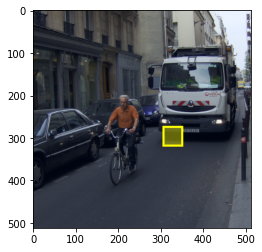

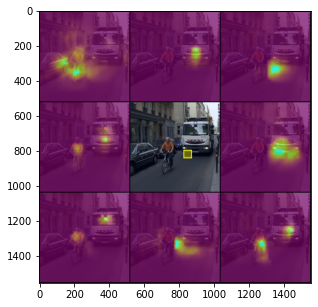

In [208]:
attn_layer_idx = -1

#box_img, avg_attn, attn_grid, img_grid, cool_img, cool_img_avg, attentions = attentions_at_loc(img, attns[attn_layer_idx], 15, 17, stride=16, rescale=True, mask_below=0)
#box_img, avg_attn, attn_grid, img_grid, cool_img, cool_img_avg, attentions = attentions_at_loc(img, attns[attn_layer_idx], 18, 9, stride=16, rescale=True, mask_below=0)
#box_img, avg_attn, attn_grid, img_grid, cool_img, cool_img_avg, attentions = attentions_at_loc(img, attns[attn_layer_idx], 18, 13, stride=16, rescale=True, mask_below=0)
box_img, avg_attn, attn_grid, img_grid, cool_img, cool_img_avg, attentions = attentions_at_loc(img, attns[attn_layer_idx], 18, 20, stride=16, rescale=True, mask_below=0)

#box_img, avg_attn, attn_grid, img_grid, cool_img, cool_img_avg = attentions_at_loc(img, attns, 26, 24, stride=16, rescale=True, mask_below=0)
plt.imshow(box_img)
# plt.figure(figsize=(8 * 5, 5))
# plt.imshow(attn_grid, cmap="viridis")
plt.figure(figsize=(8 * 5, 5))
plt.imshow(cool_img)

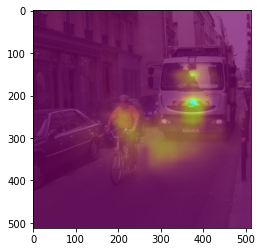

In [209]:
plt.imshow(cool_img_avg)

In [158]:
plt.imsave('on.png',cool_img_avg)


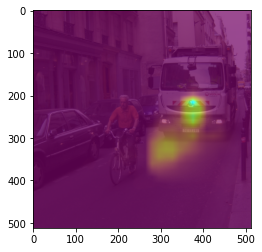

In [215]:
idx = [1,2]
chosen_attn = make_avg_specific_idx(attentions,img, idx)
plt.imshow(chosen_attn)

In [216]:
plt.imsave('on.png',chosen_attn)

In [ ]:
plt.imsave("val_loc_and_attn_map_1.png", cool_img)

##

In [479]:
path = "sample_images/sample_baseball.jpg"
img, attns = get_attentions(model, path)

In [448]:
img_grid.max()

255

In [474]:
plt.imsave("loc_and_attn_map_3.png", cool_img)

tensor([[304,  80, 352, 128]])


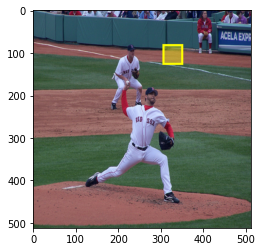

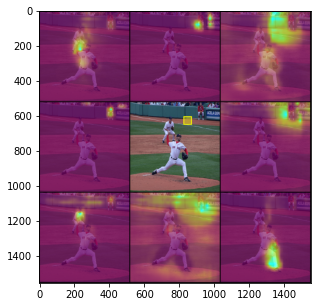

In [429]:
box_img, avg_attn, attn_grid, img_grid, cool_img = attentions_at_loc(img, attns, 6, 20, stride=16, rescale=True)
plt.imshow(box_img)
# plt.figure(figsize=(8 * 5, 5))
# plt.imshow(attn_grid, cmap="viridis")
plt.figure(figsize=(8 * 5, 5))
plt.imshow(cool_img)

In [250]:
plt.imsave("example_loc.png", box_img)

In [242]:
plt.imsave("example_attention_map.png", img_grid)

In [196]:
import cv2

In [40]:
attn_grid.shape

(516, 4114)

In [47]:
from skimage import exposure 
import numpy as np

In [69]:
attn_grid.shape

(516, 4114)

In [60]:
map_img = exposure.rescale_intensity(attn_grid, out_range=(0, 255))
map_img = np.uint8(map_img)


In [52]:
cv2.imshow('frame', heatmap_img)

In [62]:
heatmap_img.shape

(516, 4114, 3)

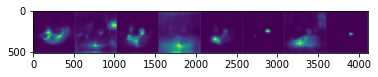

In [61]:
plt.imshow(map_img)

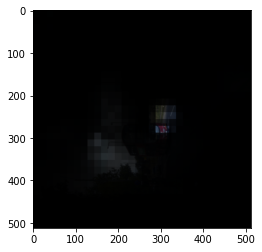

In [33]:
plt.imshow((box_img.transpose(2, 1, 0) * avg_attn).transpose(1, 2, 0))

In [33]:
import numpy as np
np.percentile(attn_grid, q=90)

0.11834836006164551

In [39]:
a = torch.arange(12).reshape(4, 3)
a.min(1)

torch.return_types.min(
values=tensor([0, 3, 6, 9]),
indices=tensor([0, 0, 0, 0]))

In [37]:
a

tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11]])

In [7]:
from openpifpaf.network.vision_transformer import vit_small, adapt_pos_embed

In [3]:
vit_s = vit_small()

In [4]:
vit_s.state_dict().keys()

odict_keys(['cls_token', 'pos_embed', 'patch_embed.proj.weight', 'patch_embed.proj.bias', 'blocks.0.norm1.weight', 'blocks.0.norm1.bias', 'blocks.0.attn.qkv.weight', 'blocks.0.attn.qkv.bias', 'blocks.0.attn.proj.weight', 'blocks.0.attn.proj.bias', 'blocks.0.norm2.weight', 'blocks.0.norm2.bias', 'blocks.0.mlp.fc1.weight', 'blocks.0.mlp.fc1.bias', 'blocks.0.mlp.fc2.weight', 'blocks.0.mlp.fc2.bias', 'blocks.1.norm1.weight', 'blocks.1.norm1.bias', 'blocks.1.attn.qkv.weight', 'blocks.1.attn.qkv.bias', 'blocks.1.attn.proj.weight', 'blocks.1.attn.proj.bias', 'blocks.1.norm2.weight', 'blocks.1.norm2.bias', 'blocks.1.mlp.fc1.weight', 'blocks.1.mlp.fc1.bias', 'blocks.1.mlp.fc2.weight', 'blocks.1.mlp.fc2.bias', 'blocks.2.norm1.weight', 'blocks.2.norm1.bias', 'blocks.2.attn.qkv.weight', 'blocks.2.attn.qkv.bias', 'blocks.2.attn.proj.weight', 'blocks.2.attn.proj.bias', 'blocks.2.norm2.weight', 'blocks.2.norm2.bias', 'blocks.2.mlp.fc1.weight', 'blocks.2.mlp.fc1.bias', 'blocks.2.mlp.fc2.weight', 'bloc

In [8]:
deit_s_sd = torch.hub.load_state_dict_from_url(
            url="https://dl.fbaipublicfiles.com/deit/deit_small_patch16_224-cd65a155.pth",
            map_location="cpu", check_hash=True
        )
state_dict = adapt_pos_embed(vit_s, deit_s_sd['model'])

In [255]:
vit_s.state_dict().keys()  deit_s_sd['model'].keys()

False

In [9]:
vit_s.load_state_dict(deit_s_sd['model'], strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['head.weight', 'head.bias'])

In [2]:
from openpifpaf.network.factory import BASE_FACTORIES

In [4]:
vit_t = BASE_FACTORIES["vit_t"]()

In [3]:
vit_b = BASE_FACTORIES["vit_b"]()

In [48]:
x = torch.randn(2, 3, 512, 512)

In [7]:
vit_t(x).shape

torch.Size([4, 1024, 192])

In [16]:
from standalone_nets.neck_transformer import JointTransformer, SoloTransformer

In [62]:
jt = JointTransformer(2048, embed_dim=256)
st = SoloTransformer(2048, embed_dim=256)